# 01. DQN

[V. Mnih et al., "Human-level control through deep reinforcement learning." Nature, 518
(7540):529–533, 2015.](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)

Reinforcement learning is known to be unstable or even to diverge when a nonlinear function approximator such as a neural network is used to represent the action-value (also known as $Q$) function. This instability has several causes: the correlations present in the sequence of observations, the fact that small updates to $Q$ may significantly change the policy and therefore change the data distribution, and the correlations between the action-values ($Q$) and the target values $r + \gamma \max_{a'} Q(s', a')$.

The authors suggest two key ideas to address these instabilities with a novel variant of Q-learning: Replay buffer and Fixed Q-target.

#### Uniformly random sampling from Experience Replay Memory

Reinforcement learning agent stores the experiences consecutively in the buffer, so adjacent ($s, a, r, s'$) transitions stored are highly likely to have correlation. To remove this, the agent samples experiences uniformly at random from the pool of stored samples $\big( (s, a, r, s') \sim U(D) \big)$. See sample_batch method of ReplayBuffer class for more details.

#### Fixed Q-target

DQN uses an iterative update that adjusts the action-values ($Q$) towards target values that are only periodically updated, thereby reducing correlations with the target; if not, it is easily divergy because the target continuously moves. The Q-learning update at iteration $i$ uses the following loss function:

$$
L_i(\theta_i) = \mathbb{E}_{(s,a,r,s') \sim U(D)} \big[ \big( r + \gamma \max_{a'} Q(s',a';\theta_i^-) - Q(s, a; \theta_i) \big)^2 \big]
$$

in which $\gamma$ is the discount factor determining the agent’s horizon, $\theta_i$ are the parameters of the Q-network at iteration $i$ and $\theta_i^-$ are the network parameters used to compute the target at iteration $i$. The target network parameters $\theta_i^-$ are only updated with the Q-network parameters ($\theta_i$) every C steps and are held fixed between individual updates. ($C = 200$ in CartPole-v0)

#### For more stability: Gradient clipping

The authors also found it helpful to clip the error term from the update $r + \gamma \max_{a'} Q(s', a'; \theta_i^-) - Q(s,a,;\theta_i)$ to be between -1 and 1. Because the absolute value loss function $|x|$ has a derivative of -1 for all negative values of x and a derivative of 1 for all positive values of x, clipping the squared error to be between -1 and 1 corresponds to using an absolute value loss function for errors outside of the (-1,1) interval. This form of error clipping further improved the stability of the algorithm.

In [73]:
import os
from typing import Dict, List, Tuple

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from ttt_env import TicTacToeEnv

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Replay buffer

Typically, people implement replay buffers with one of the following three data structures:

  - collections.deque
  - list
  - numpy.ndarray
  
**deque** is very easy to handle once you initialize its maximum length (e.g. deque(maxlen=buffer_size)). However, the indexing operation of deque gets terribly slow as it grows up because it is [internally doubly linked list](https://wiki.python.org/moin/TimeComplexity#collections.deque). On the other hands, **list** is an array, so it is relatively faster than deque when you sample batches at every step. Its amortized cost of  *Get item* is [O(1)](https://wiki.python.org/moin/TimeComplexity#list).

Last but not least, let's see **numpy.ndarray**. numpy.ndarray is even faster than list due to the fact that it is [a homogeneous array of fixed-size items](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html#numpy.ndarray), so you can get the benefits of [locality of reference](https://en.wikipedia.org/wiki/Locality_of_reference). Whereas list is an array of pointers to objects, even when all of them are of the same type.

Here, we are going to implement a replay buffer using numpy.ndarray.


Reference: [OpenAI spinning-up](https://github.com/openai/spinningup/blob/master/spinup/algos/sac/sac.py#L10)

## Network

We are going to use a simple network architecture with three fully connected layers and two non-linearity functions (ReLU).

## DQN Agent

Here is a summary of DQNAgent class.

| Method           | Note                                                 |
| ---              | ---                                                  |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|compute_dqn_loss  | return dqn loss.                                     |
|update_model      | update the model by gradient descent.                |
|target_hard_update| hard update from the local model to the target model.|
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|plot              | plot the training progresses.                        |


## Environment

You can see the [code](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/cartpole.py) and [configurations](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/cartpole.py#L91) of CartPole-v1 from Farama Gymnasium's repository.

In [74]:
# environment
env = TicTacToeEnv(board_size=3)

## Set random seed

In [75]:
seed = 777

def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

np.random.seed(seed)
seed_torch(seed)

## Initialize

In [76]:
from dqn import DQNAgent

# parameters
num_frames = 1000
memory_size = 100
batch_size = 32
target_update = 100
epsilon_decay = 1 / 2000

agent = DQNAgent(env, memory_size, batch_size, target_update, epsilon_decay, seed)

cpu


## Train

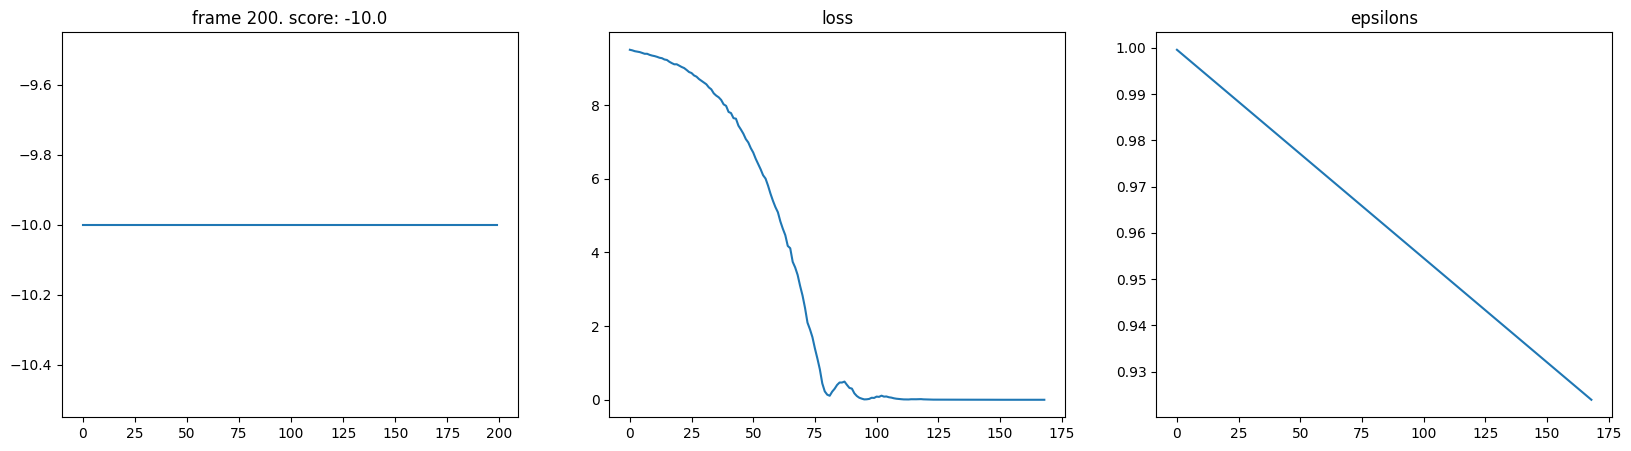

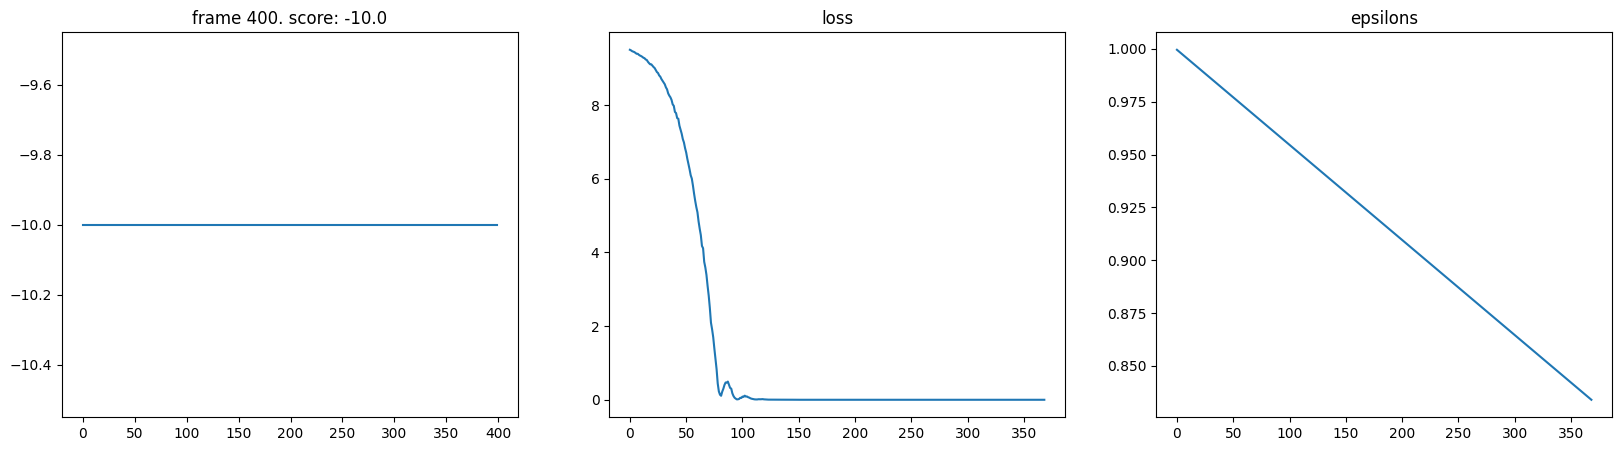

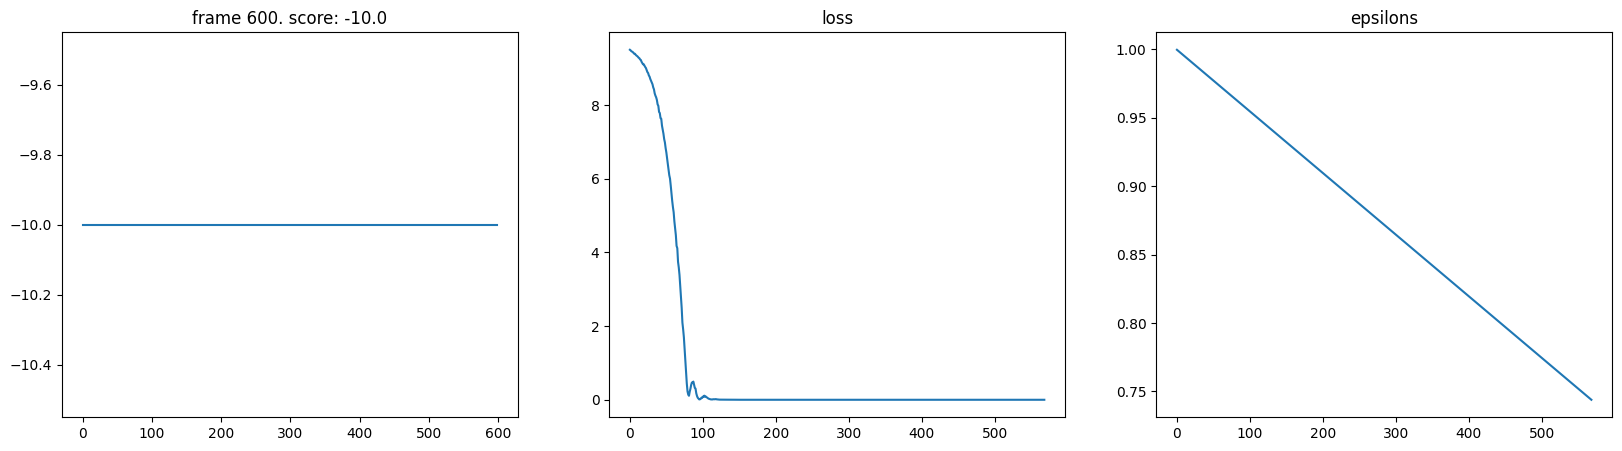

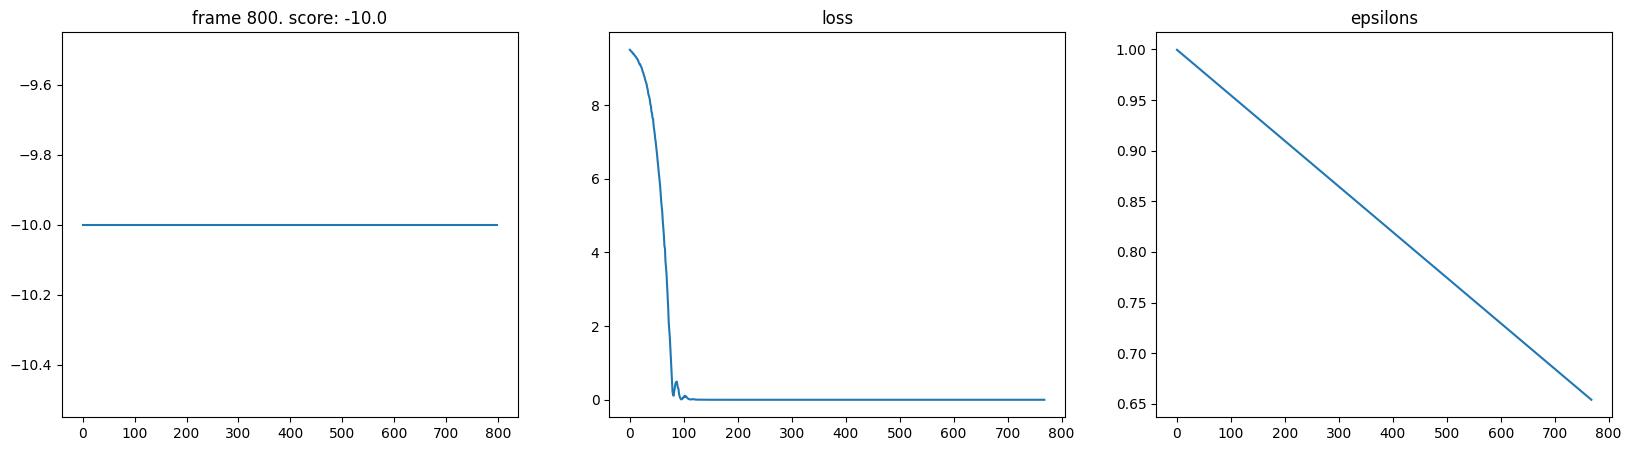

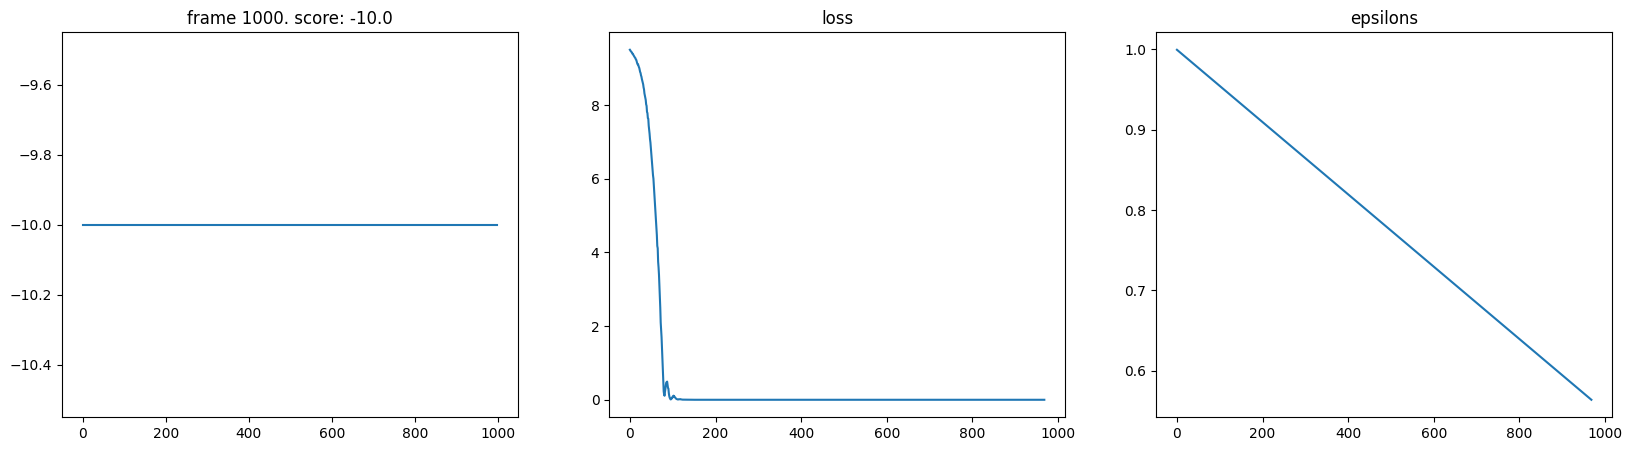

In [77]:
agent.train(num_frames)

In [78]:
agent.memory.obs_buf

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0.

## Test

Run the trained agent (1 episode).

In [79]:
video_folder="videos/dqn"
agent.test(video_folder=video_folder)

c:\Users\Admin\Desktop\CS\AI_tic_tac_toe\backend\venv\Lib\site-packages\gym\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at c:\Users\Admin\Desktop\CS\AI_tic_tac_toe\backend\demo\videos\dqn folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


DependencyNotInstalled: MoviePy is not installed, run `pip install moviepy`